Deep Models for Text and Sequences
=============

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [16]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import string
import numpy as np

Download the data from the source website if necessary.

In [17]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [18]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [19]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [20]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'term', 'anarchism', 'originated', 'of', 'term', 'as']


Train a skip-gram model.

In [21]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                                     labels=train_labels, num_sampled=num_sampled,
                                                     num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [22]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.178965
Nearest to been: pnc, plutarch, giza, lindbergh, mindfulness, present, caballero, ayya,
Nearest to system: scant, sizes, samples, suited, grosbeak, steppes, befell, soldiers,
Nearest to and: fast, cannibalistic, eels, samadhi, yuen, no, excision, prequel,
Nearest to only: dusting, pollutants, customization, daytime, tails, acquainted, chechens, melt,
Nearest to from: servicio, squealer, nour, unaids, thirst, dassault, unforgettable, idyllic,
Nearest to will: brush, microtonal, arameans, teller, eyewitness, thematic, mcveigh, mirroring,
Nearest to many: athens, pwnage, kilts, arenas, genitalia, pollution, moivre, alcmene,
Nearest to into: cegep, intricate, larps, sprengel, solidifying, serling, february, artefacts,
Nearest to than: caledonia, unusual, dative, fiancee, consortium, antigens, acrobatics, purify,
Nearest to or: resemblances, stylistic, excise, hollow, bro, bankrupt, baptist, multiplicity,
Nearest to their: regiments, robb, gladst

Check that the embeddings are normalized:

In [23]:
print(np.sum(np.square(final_embeddings[0])))

1.0


In [25]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

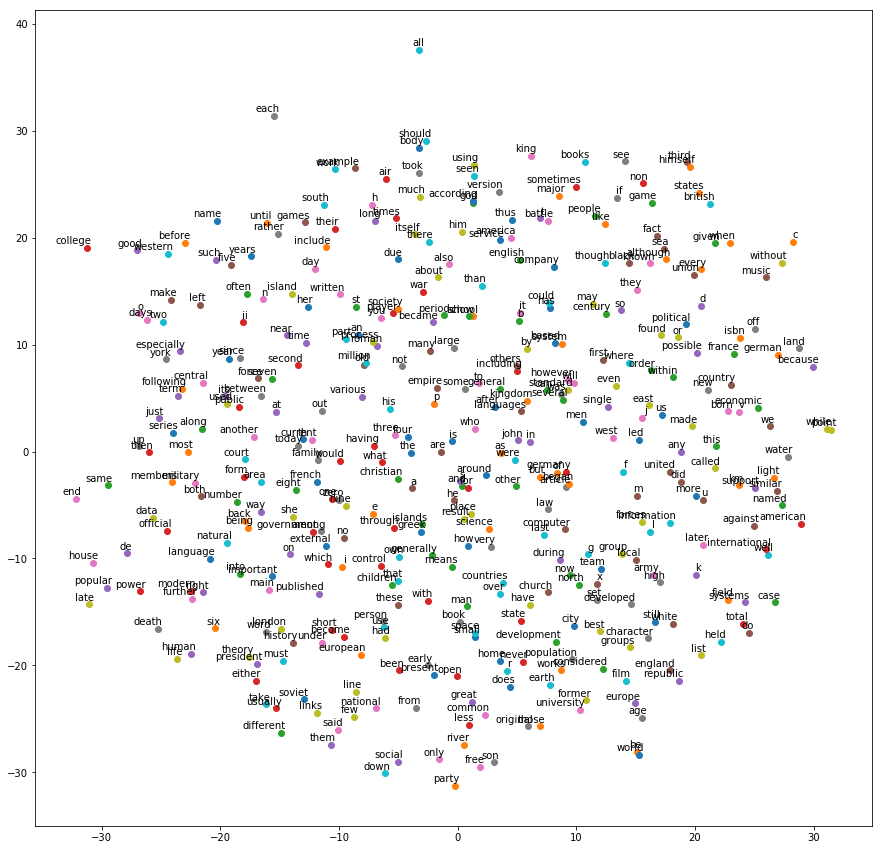

In [26]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [27]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'a', 'term', 'term', 'originated', 'of', 'as']


In [28]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                                     labels=train_labels, num_sampled=num_sampled,
                                                     num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.834412
Nearest to into: mascarenhas, manic, gst, totalitarian, sanctity, modifications, guerra, ministership,
Nearest to with: microchips, suggestive, polynesian, repository, buber, prominently, hijacked, assembler,
Nearest to one: strongholds, thuringia, seconded, chronically, incidental, wickham, picirilli, an,
Nearest to his: zama, hidden, sauk, synods, allgemeine, selamat, tumour, campaigners,
Nearest to united: oppenheimer, beneficial, tremble, tyson, cegep, pagans, enacts, sentry,
Nearest to than: sacked, laozi, steyn, materially, frighten, laureate, emissary, inkjet,
Nearest to in: abt, sneaking, sunlight, baseball, lorica, sunsets, carolingian, macrocosm,
Nearest to or: xers, husbands, revoluci, hoboken, hussite, mistrust, beneficial, mordred,
Nearest to of: booting, continuo, dischord, sculptor, liberally, klansmen, ovule, heaviest,
Nearest to known: josaphat, goryeo, iran, waterbury, novgorod, myron, forecasting, injury,
Nearest to state:

In [ ]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [ ]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)

Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    name = f.namelist()[0]
    data = tf.compat.as_str(f.read(name))
  return data
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [5]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [6]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [7]:
batch_size=64
num_unrollings=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f certain d', 'at it will ', 'e convince ', 'ent told hi', 'ampaign and', 'rver side s', 'ious texts ', 'o capitaliz', 'a duplicate', 'gh ann es d', 'ine january', 'ross zero t', 'cal theorie', 'ast instanc', ' dimensiona', 'most holy m', 't s support', 'u is still ', 'e oscillati', 'o eight sub', 'of italy la', 's the tower', 'klahoma pre', 'erprise lin', 'ws becomes ', 'et in a naz', 'the fabian ', 'etchy to re', ' sharman ne', 'ised empero', 'ting in pol', 'd neo latin', 'th risky ri', 'encyclopedi', 'fense the a', 'duating fro', 'treet grid ', 'ations more', 'appeal of d', 'si have mad']
['ists advoca', 'ary governm', 'hes nat

In [8]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

Simple LSTM Model.

In [9]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [10]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.301454 learning rate: 10.000000
Minibatch perplexity: 27.15
uawweaufihch yionmrees pnsf io thqja jax mevee sheo r upeedxejsatig pcyls  uhnia
ox r gzeplpqnhumvdfase tvah  zlc anam pgtpdt  rsaihagaiqol fz utlrg x aa vtehbam
czpibxeevnegihso  ho ywioajhgpiqicrfccevx geqjsayhmxf v te fgtk hduy ienwlszihmu
vmq bojeefuotewsedmpnq  tqgvt c praeyntoa em itnmakr  uthnt qnrtaacepnsakn bdm c
ggxjosu mmtoooraybhv mhi ofvaipztssemr oxvglasqtee kmrnerfhn vnroydb pfqixxrei o
Validation set perplexity: 20.29
Average loss at step 100: 2.594385 learning rate: 10.000000
Minibatch perplexity: 11.00
Validation set perplexity: 10.30
Average loss at step 200: 2.245976 learning rate: 10.000000
Minibatch perplexity: 8.64
Validation set perplexity: 8.61
Average loss at step 300: 2.096692 learning rate: 10.000000
Minibatch perplexity: 7.53
Validation set perplexity: 8.10
Average loss at step 400: 1.998163 learning rate: 10.000000
Minibatch perplexity: 7.46
Validation set per

Validation set perplexity: 4.40
Average loss at step 4500: 1.617740 learning rate: 10.000000
Minibatch perplexity: 5.25
Validation set perplexity: 4.58
Average loss at step 4600: 1.613265 learning rate: 10.000000
Minibatch perplexity: 4.86
Validation set perplexity: 4.62
Average loss at step 4700: 1.625040 learning rate: 10.000000
Minibatch perplexity: 4.98
Validation set perplexity: 4.45
Average loss at step 4800: 1.630344 learning rate: 10.000000
Minibatch perplexity: 4.34
Validation set perplexity: 4.46
Average loss at step 4900: 1.628491 learning rate: 10.000000
Minibatch perplexity: 5.10
Validation set perplexity: 4.52
Average loss at step 5000: 1.603884 learning rate: 1.000000
Minibatch perplexity: 4.58
ny a lext s thiod defined been first battor was to coindsnaine whitzen each disc
rmat llasinally stater five juris and marin reall ack wite the had couption and 
s lessite everation yer immp on taxs grow belion coust five one jorant scakeve a
victy in informer their or prize its s

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---